In [9]:
import os
import math
import random
import numpy as np
import pandas as pd

from skimage import io, filters, color, segmentation
from skimage.transform import resize
from skimage.util import crop

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import keras
from keras import losses, models, optimizers
from keras.layers import (Activation, Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D)

import matplotlib.pyplot as plt
import plotly.express as px

In [10]:
def with_probability(p):
    return p>random.random()

BAD, GOOD = 0, 1
CAT_BAD, CAT_GOOD = [1, 0], [0, 1]
IMG_WIDTH, IMG_HEIGHT = 150, 150 
CROP_SIZE = ((11, 11), (11, 11), (0, 0))

path = "/kaggle/input/cnmc-leukemia"

X = []
Y = []
YCAT = []

for subdir in ["/fold_0/fold_0", "/fold_1/fold_1", "/fold_2/fold_2"]:
    for label, numeric, category in [("/all/", BAD, CAT_BAD), ("/hem/", GOOD, CAT_GOOD)]:
        _path = path + subdir + label
        print("Subdirectory", _path, end="")
        for image_path in os.listdir(_path):
            if numeric == BAD and with_probability(0.38): continue
            img = io.imread(_path + image_path)
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), anti_aliasing=True)
            img = crop(img, CROP_SIZE)
            X.append(img)
            Y.append(numeric)
            YCAT.append(category)
        print(" ... done")
            
print(len(X))
print(len(Y))

Subdirectory /kaggle/input/cnmc-leukemia/fold_0/fold_0/all/ ... done
Subdirectory /kaggle/input/cnmc-leukemia/fold_0/fold_0/hem/ ... done
Subdirectory /kaggle/input/cnmc-leukemia/fold_1/fold_1/all/ ... done
Subdirectory /kaggle/input/cnmc-leukemia/fold_1/fold_1/hem/ ... done
Subdirectory /kaggle/input/cnmc-leukemia/fold_2/fold_2/all/ ... done
Subdirectory /kaggle/input/cnmc-leukemia/fold_2/fold_2/hem/ ... done
7878
7878


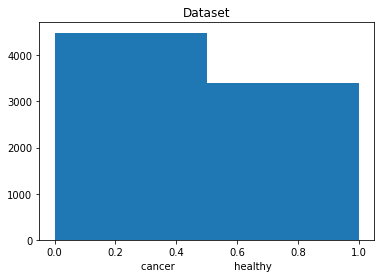

In [11]:
plt.hist(Y, bins=2,)
plt.title("Dataset")
plt.xlabel("cancer                   healthy")
plt.show()

In [12]:
X = np.array(X)
Y = np.array(Y)
YCAT = np.array(YCAT)

print("X converted to np array of shape", X.shape)
print("Y converted to np array of shape", Y.shape)

X converted to np array of shape (7878, 128, 128, 1)
Y converted to np array of shape (7878,)


Randomly chosen cell 2948 is cancer , cat.array: [1 0]


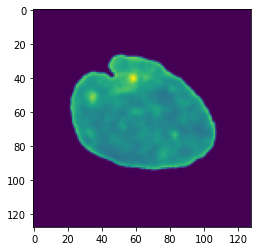

Randomly chosen cell 7849 is healthy , cat.array: [0 1]


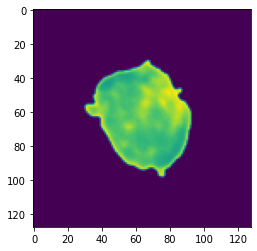

Randomly chosen cell 1921 is healthy , cat.array: [0 1]


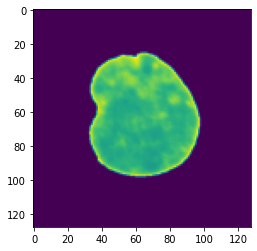

Randomly chosen cell 4379 is healthy , cat.array: [0 1]


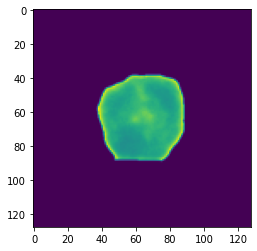

In [13]:
for i in range(4):
    t = random.randint(0, X.shape[0])
    print("Randomly chosen cell", t, "is", "healthy" if Y[t] == GOOD else "cancer", ", cat.array:", YCAT[t])
    plt.imshow(X[t])
    plt.show()

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, YCAT, test_size=0.2, random_state=None)
print(x_train.shape)
print(x_test.shape)

(6302, 128, 128, 1)
(1576, 128, 128, 1)


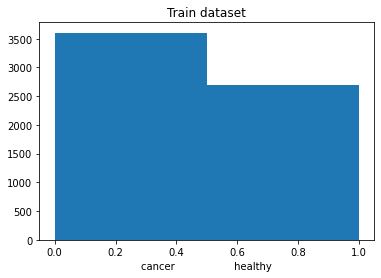

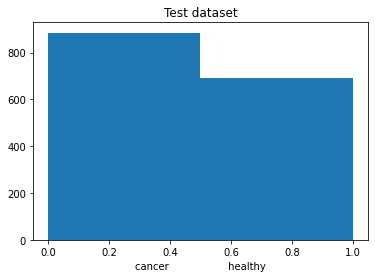

In [15]:
plt.hist(list(map(lambda a: a[1], y_train)), bins=2)
plt.title("Train dataset")
plt.xlabel("cancer                   healthy")
plt.show()

plt.hist(list(map(lambda a: a[1], y_test)), bins=2)
plt.title("Test dataset")
plt.xlabel("cancer                   healthy")
plt.show()

In [16]:
model = models.Sequential([
    Conv2D(16, kernel_size=(5, 5), kernel_initializer="lecun_uniform", activation="selu", input_shape=(128, 128, 1)),
    Conv2D(16, kernel_size=(5, 5), kernel_initializer="lecun_uniform", activation="selu"),
    MaxPooling2D(),
    Dropout(0.11),
    
    Conv2D(32, kernel_size=(5, 5), activation="relu"),
    Conv2D(32, kernel_size=(5, 5), activation="relu"),
    AveragePooling2D(),
    Dropout(0.15),
    
    Conv2D(64, kernel_size=(5, 5), activation="relu"),
    MaxPooling2D(),
    Dropout(0.23),
    
    Conv2D(128, kernel_size=(4, 4), activation="relu"),
    MaxPooling2D(),
    Dropout(0.31),
    
    Flatten(),
    
    Dense(256, activation="relu"),
    Dropout(0.41),
    
    Dense(64, activation="relu"),
    Dropout(0.35),
    
    Dense(16, activation="relu"),
    Dropout(0.31),
    
    Dense(2, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 16)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 16)      6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 32)        25632     
_________________________________________________________________
average_pooling2d (AveragePo (None, 26, 26, 32)        0

2022-12-12 16:52:18.450194: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2022-12-12 16:52:20.509944: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
197/197 [==============================] - 103s 512ms/step - loss: 0.6313 - accuracy: 0.6657
Epoch 2/20
197/197 [==============================] - 94s 477ms/step - loss: 0.5397 - accuracy: 0.7659
Epoch 3/20
197/197 [==============================] - 94s 477ms/step - loss: 0.5244 - accuracy: 0.7644
Epoch 4/20
197/197 [==============================] - 94s 478ms/step - loss: 0.5120 - accuracy: 0.7705
Epoch 5/20
197/197 [==============================] - 94s 476ms/step - loss: 0.5045 - accuracy: 0.7721
Epoch 6/20
197/197 [==============================] - 94s 475ms/step - loss: 0.5067 - accuracy: 0.7744
Epoch 7/20
197/197 [==============================] - 94s 476ms/step - loss: 0.5026 - accuracy: 0.7782
Epoch 8/20
197/197 [==============================] - 94s 478ms/step - loss: 0.5019 - accuracy: 0.7818
Epoch 9/20
197/197 [==============================] - 95s 484ms/step - loss: 0.5021 - accuracy: 0.7764
Epoch 10/20
197/197 [==============================] - 94s 479ms/step - 

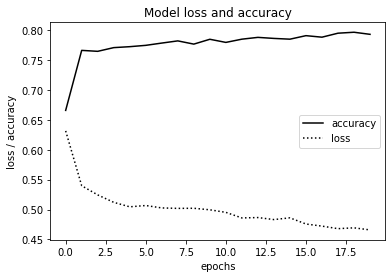

TRUE CANCER: 766 (75.99%)
FALSE CANCER: 242 (24.01%)
TRUE HEALTHY: 449 (79.05%)
KILLED: 119 (20.95%) 


Confusion matrix:


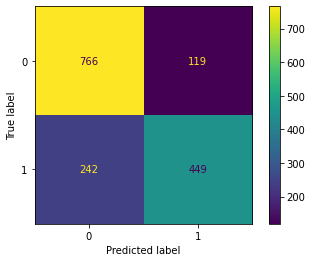

In [17]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=20, verbose=1)

plt.plot(history.history['accuracy'], 'k')
plt.plot(history.history['loss'], 'k:')
plt.title('Model loss and accuracy')
plt.ylabel('loss / accuracy')
plt.xlabel('epochs')
plt.legend(['accuracy', 'loss'], loc='right')
plt.show()

y_pred = model.predict(x_test)
cm = confusion_matrix(list(map(np.argmax, y_test)), list(map(np.argmax, y_pred))) 

print(f"TRUE CANCER: {cm[0][0]} ({100*cm[0][0]/(cm[0][0]+cm[1][0]):.2f}%)")
print(f"FALSE CANCER: {cm[1][0]} ({100*cm[1][0]/(cm[0][0]+cm[1][0]):.2f}%)")
print(f"TRUE HEALTHY: {cm[1][1]} ({100*cm[1][1]/(cm[1][1]+cm[0][1]):.2f}%)")
print(f"KILLED: {cm[0][1]} ({100*cm[0][1]/(cm[1][1]+cm[0][1]):.2f}%) \n\n")

print("Confusion matrix:")
ConfusionMatrixDisplay(cm).plot()
plt.show()

Randomly chosen cell 3959 is cancer


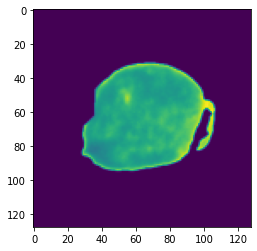

Category arrays for the cell:
True: [1 0] -- cancer
Predicted: [0.965891   0.03410903] -- 96.59% sure it is cancer

-------------------------------------------------------------------


Randomly chosen cell 2074 is healthy


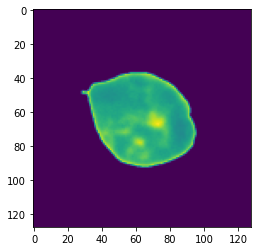

Category arrays for the cell:
True: [0 1] -- healthy
Predicted: [0.4697474 0.5302525] -- 53.03% sure it is healthy

-------------------------------------------------------------------


Randomly chosen cell 309 is cancer


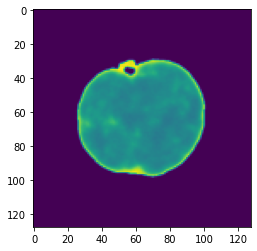

Category arrays for the cell:
True: [1 0] -- cancer
Predicted: [0.8912946  0.10870539] -- 89.13% sure it is cancer

-------------------------------------------------------------------


Randomly chosen cell 7479 is healthy


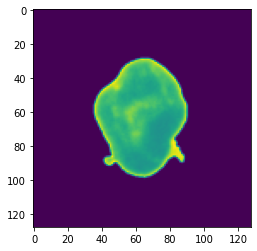

Category arrays for the cell:
True: [0 1] -- healthy
Predicted: [0.48445845 0.5155415 ] -- 51.55% sure it is healthy

-------------------------------------------------------------------




In [18]:
for i in range(4):
    t = random.randint(0, X.shape[0])
    print("Randomly chosen cell", t, "is", "healthy" if Y[t] == GOOD else "cancer")
    plt.imshow(X[t])
    plt.show()

    model_result = np.array(model(np.array([X[t]]), training=False)[0])
    print("Category arrays for the cell:")
    print(f"True: {YCAT[t]} --", "healthy" if Y[t] == GOOD else "cancer")
    print(f"Predicted: {model_result} -- {100*np.max(model_result):.2f}% sure it is", "healthy" if np.argmax(model_result) == GOOD else "cancer")
    print("\n-------------------------------------------------------------------\n\n")

In [19]:
model.layers

In [20]:
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense_3/Softmax:0', description="created by layer 'dense_3'")


(5, 5, 1, 16)
filter weights for layer 0


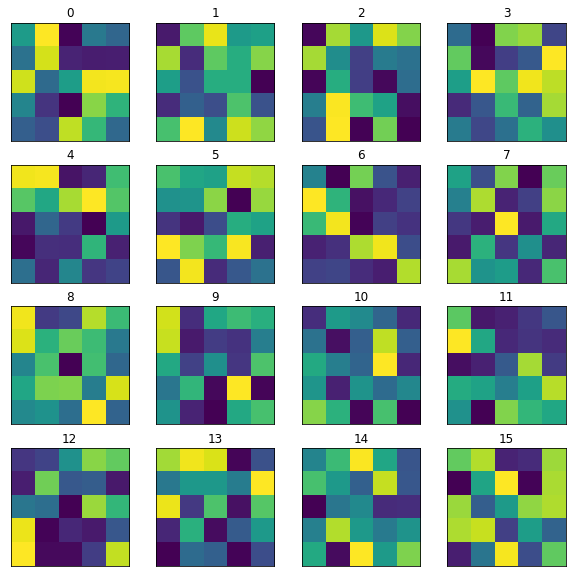

In [21]:
first_layer = model.layers[0]

weights_map = np.array( first_layer.weights[0] )
wmsh = weights_map.shape
print(wmsh)

weights_map_T = np.empty((wmsh[3], wmsh[0], wmsh[1], wmsh[2]))
for a0 in range(wmsh[0]):
    for a1 in range(wmsh[1]):
        for a2 in range(wmsh[2]):
            for a3 in range(wmsh[3]):
                weights_map_T[a3][a0][a1][a2] = weights_map[a0][a1][a2][a3]

plt.figure(figsize=(10,10))
print("filter weights for layer 0")
for a0 in range(wmsh[3]):
    ax = plt.subplot(4, 4, a0+1)
    ax.set_title(a0)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(weights_map_T[a0])
plt.show()

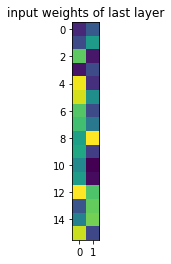

In [22]:
print(model.layers[-1])
plt.imshow(np.array(model.layers[-1].weights[0]))
plt.title("input weights of last layer")
plt.show()

Randomly chosen cell 6755 is cancer


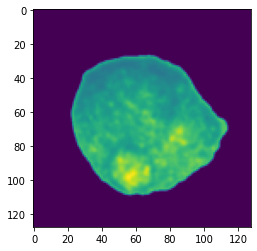

Output of first layer has shape (124, 124, 16)


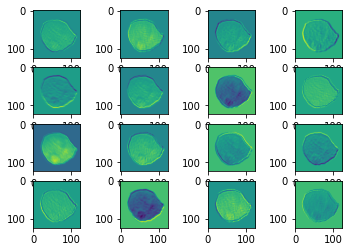

In [23]:
t = 6755
print("Randomly chosen cell", t, "is", "healthy" if Y[t] == GOOD else "cancer")
plt.imshow(X[t])
plt.show()

first_layer = model.layers[0]
first_out = first_layer(np.array([X[t]]))[0]
print("Output of first layer has shape", first_out.shape)

for a0 in range(16):
    ax = plt.subplot(4, 4, a0+1)
    plt.imshow(first_out[:, :, a0])

plt.show()

0 : conv2d
(None, 124, 124, 16)


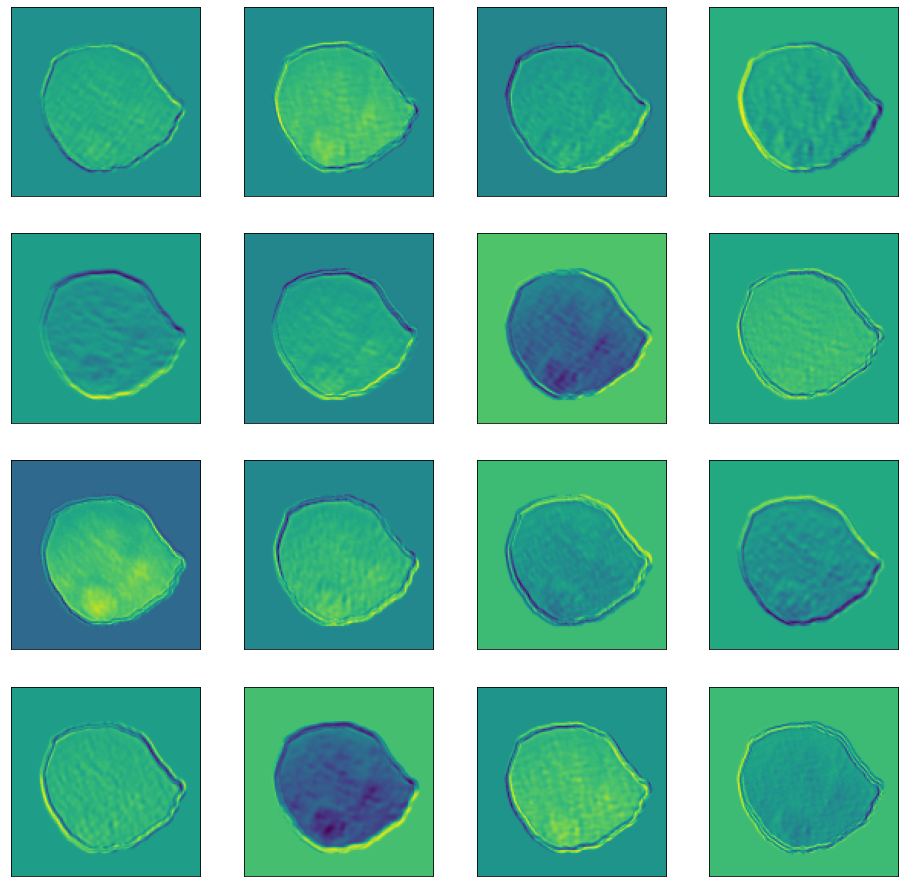


------

1 : conv2d_1
(None, 120, 120, 16)


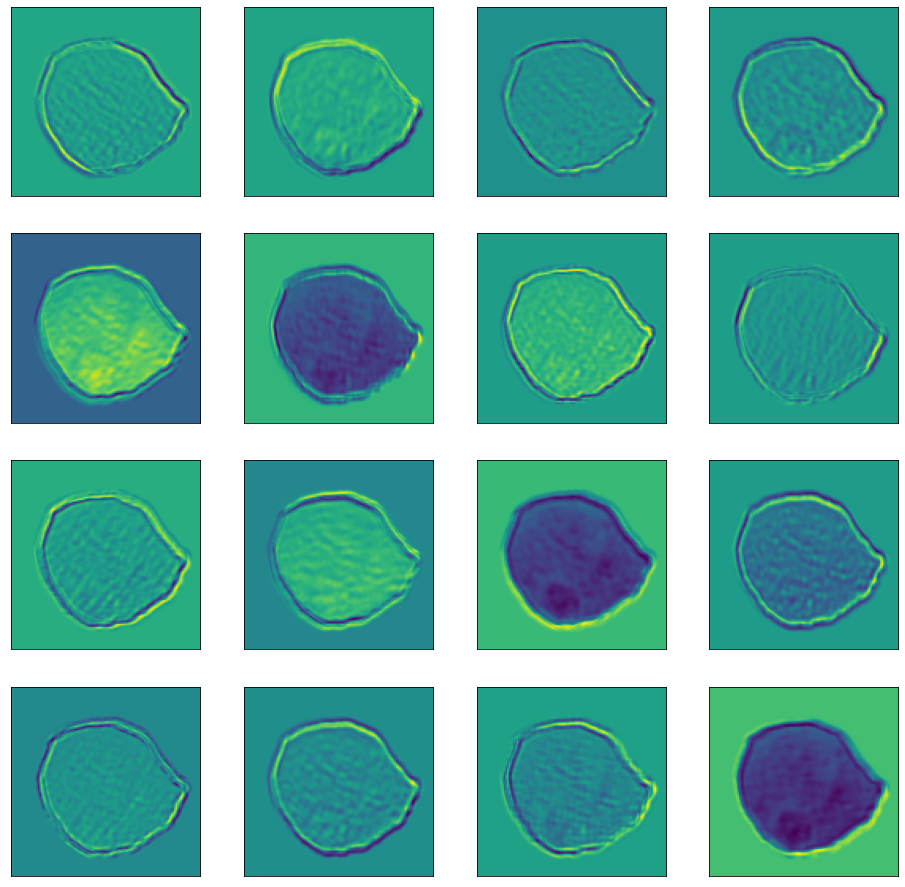


------

2 : max_pooling2d
(None, 60, 60, 16)


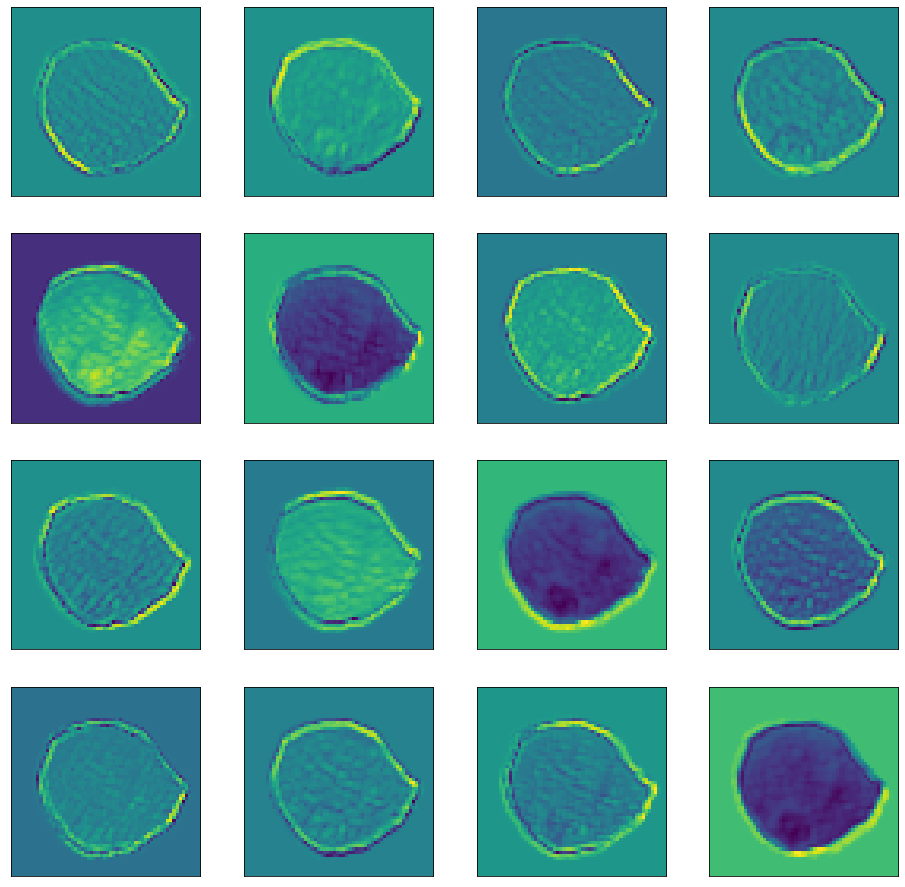


------

3 : dropout
(None, 60, 60, 16)
Dropout is not interesting. Skip.

------

4 : conv2d_2
(None, 56, 56, 32)


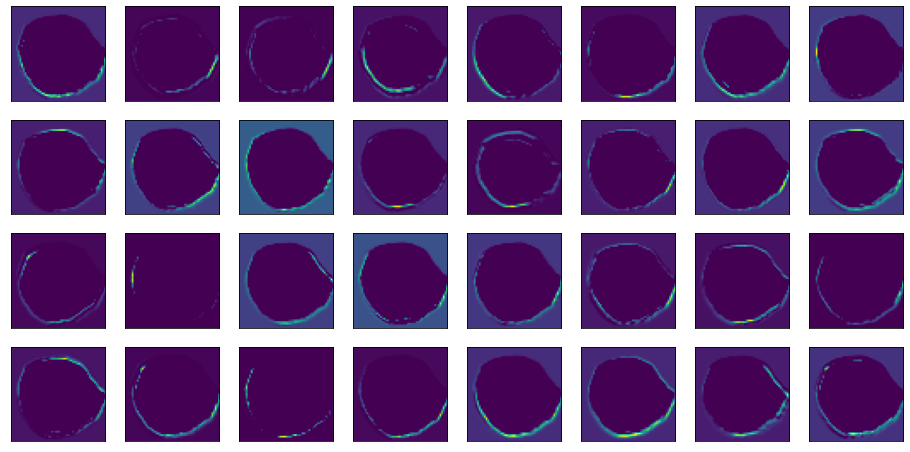


------

5 : conv2d_3
(None, 52, 52, 32)


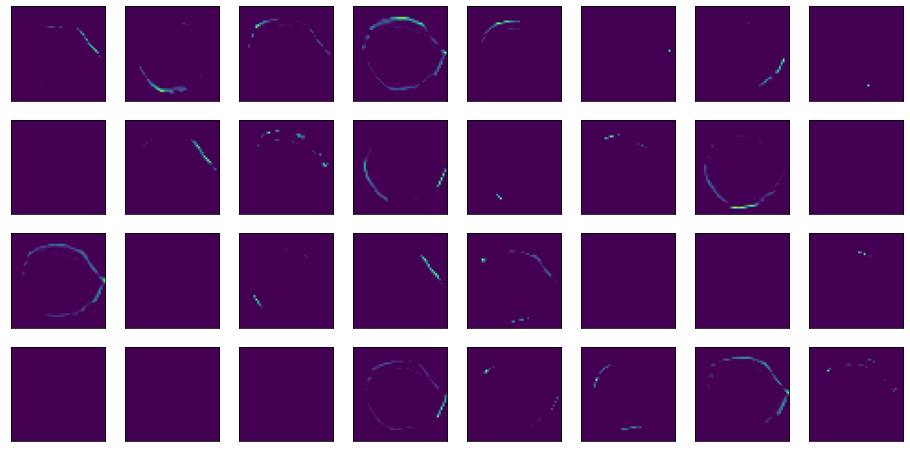


------

6 : average_pooling2d
(None, 26, 26, 32)


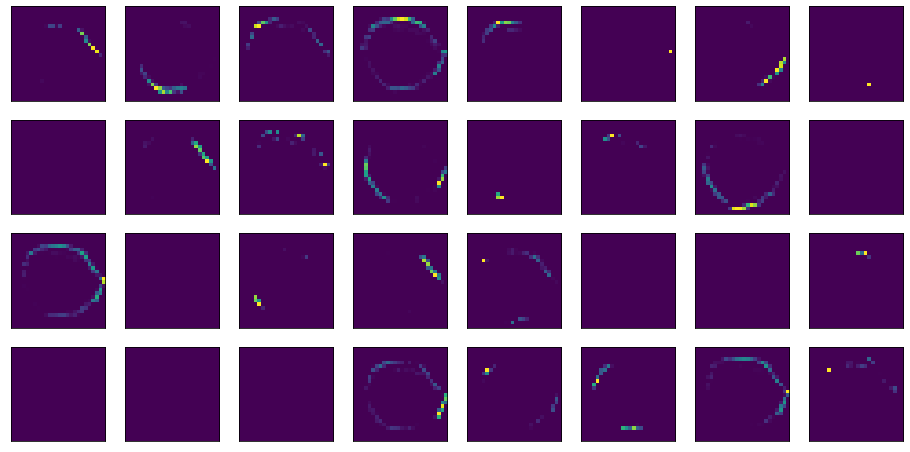


------

7 : dropout_1
(None, 26, 26, 32)
Dropout is not interesting. Skip.

------

8 : conv2d_4
(None, 22, 22, 64)


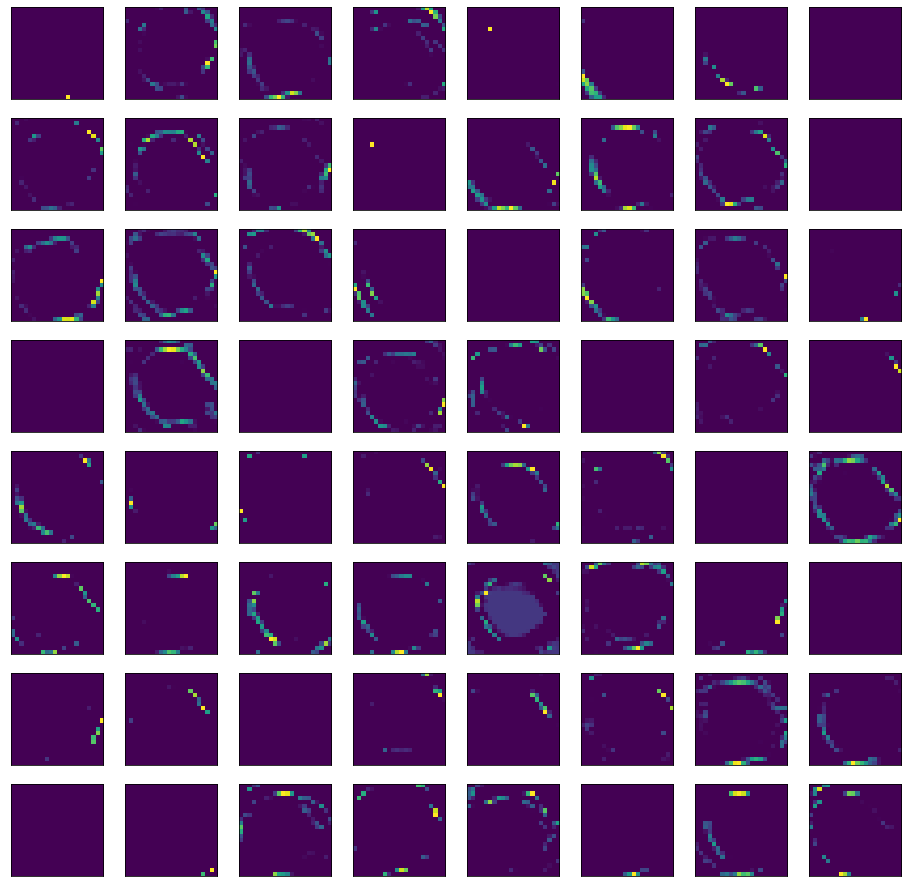


------

9 : max_pooling2d_1
(None, 11, 11, 64)


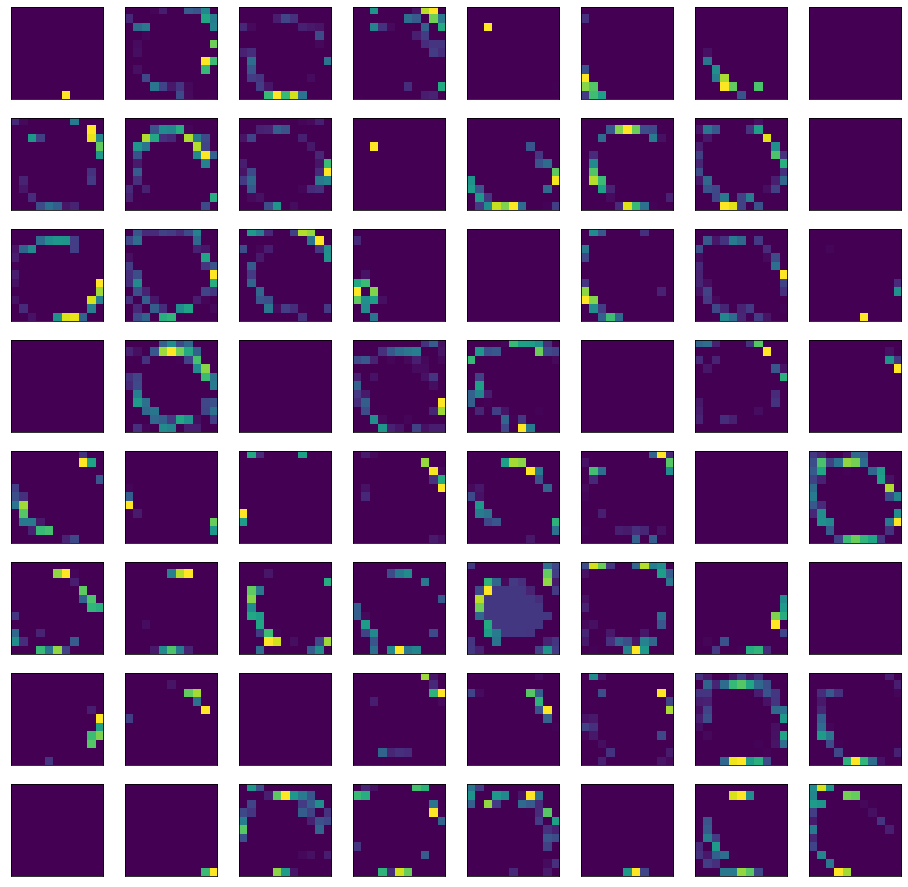


------

10 : dropout_2
(None, 11, 11, 64)
Dropout is not interesting. Skip.

------

11 : conv2d_5
(None, 8, 8, 128)


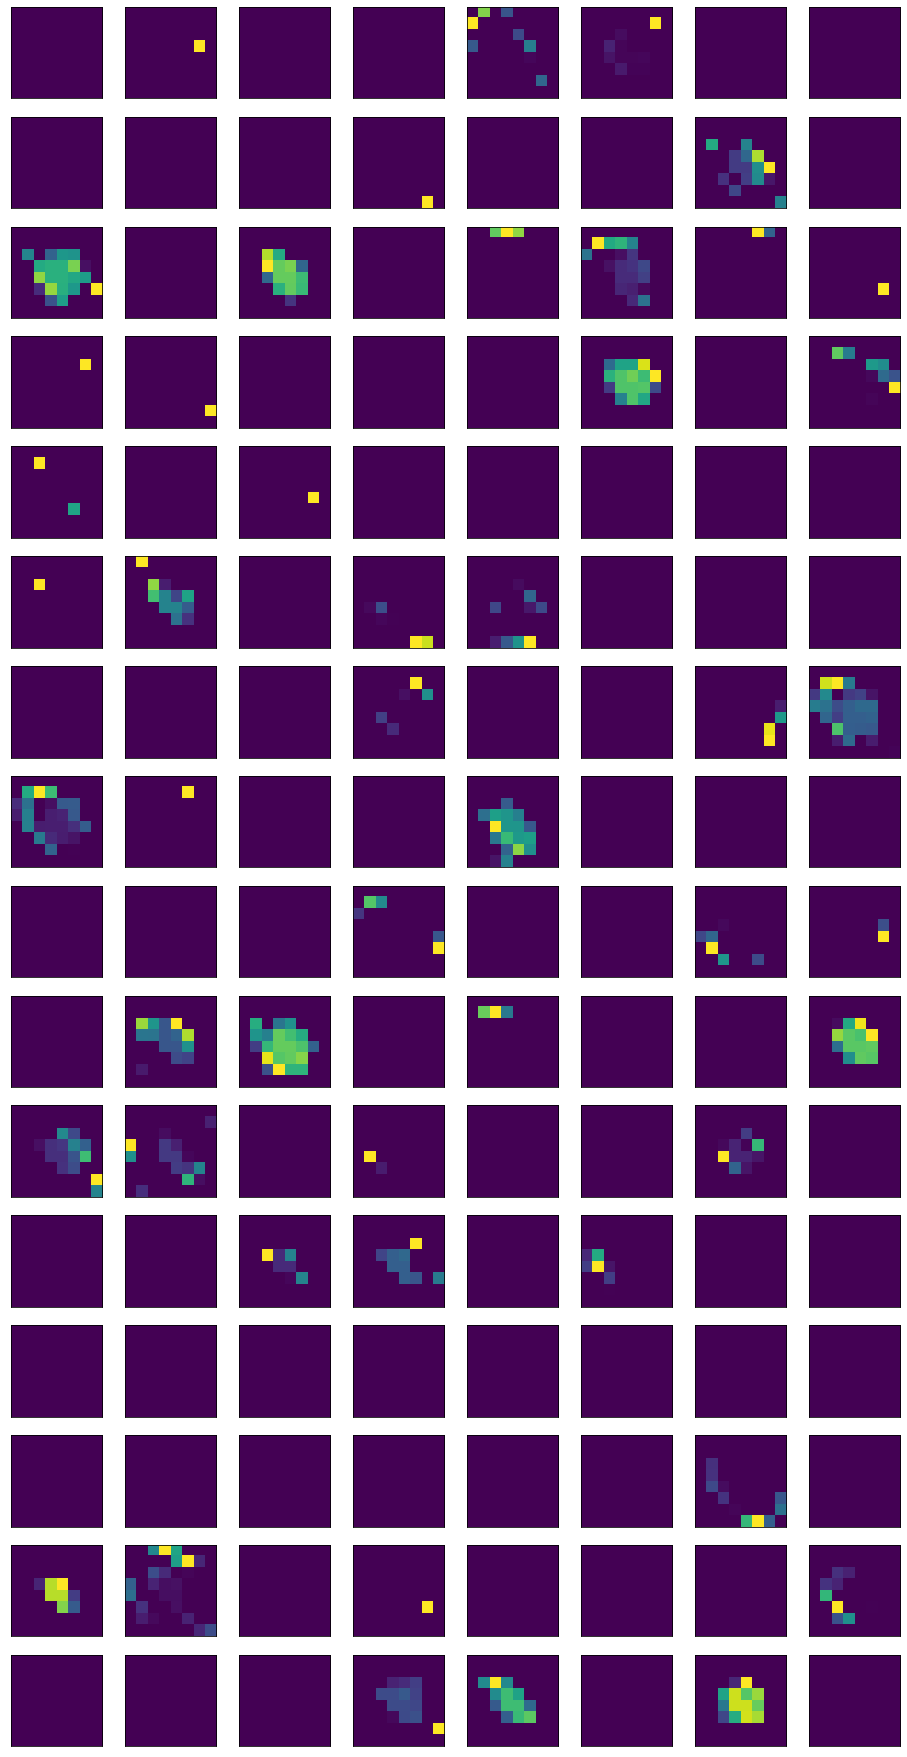


------

12 : max_pooling2d_2
(None, 4, 4, 128)


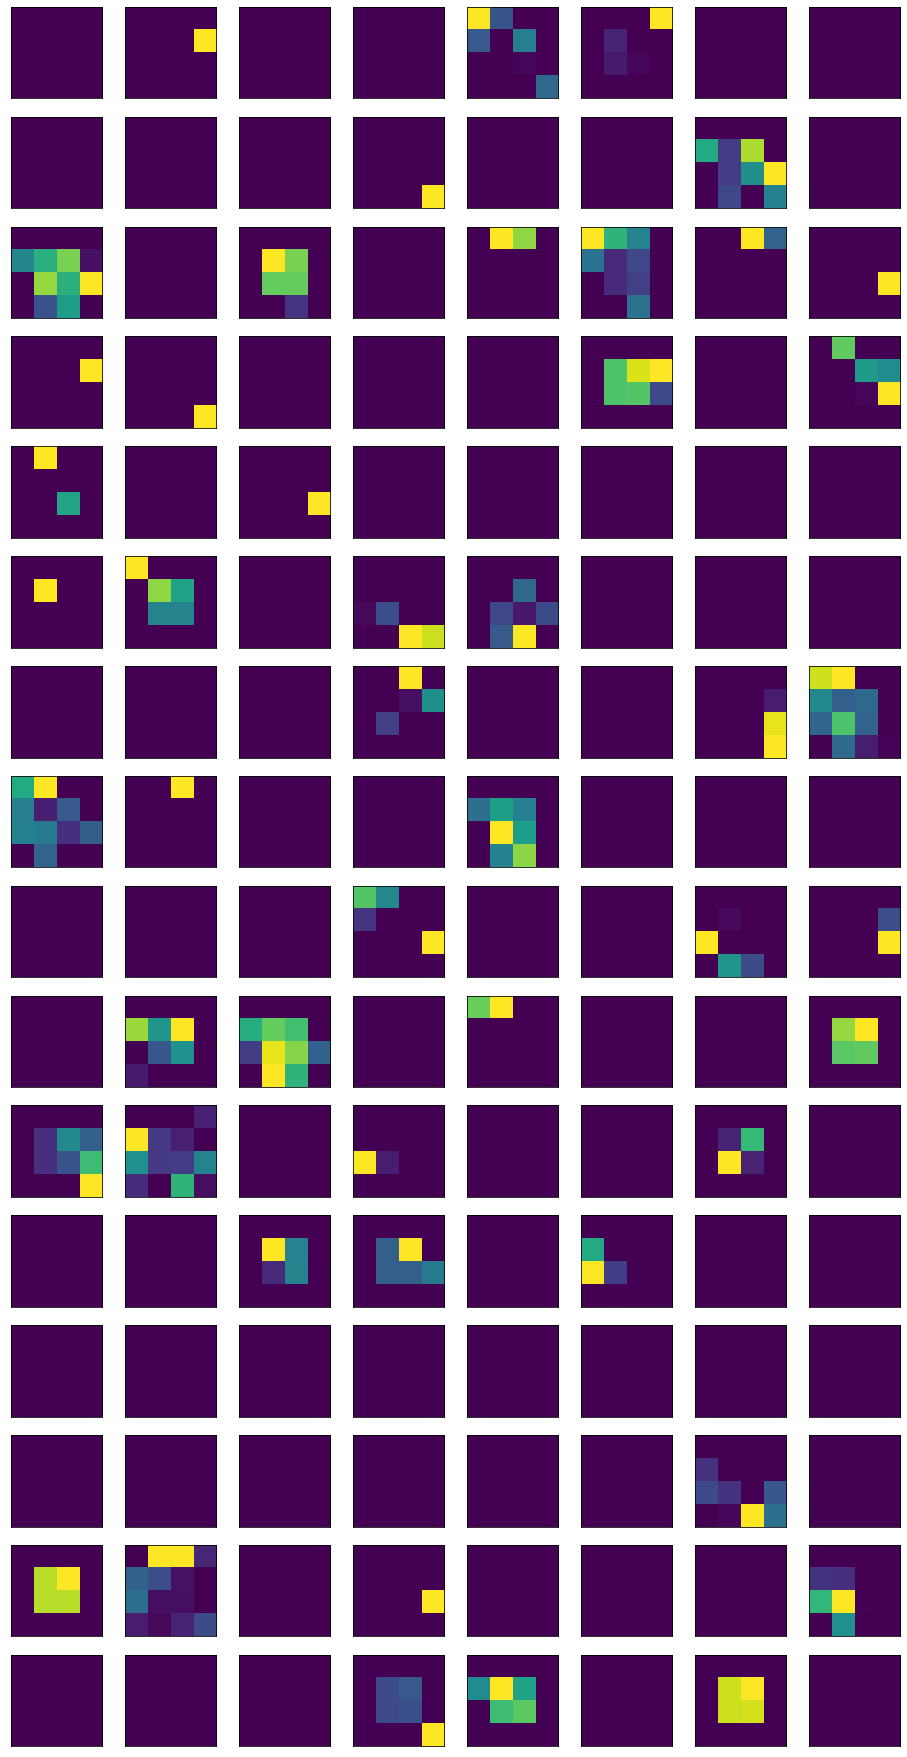


------

13 : dropout_3
(None, 4, 4, 128)
Dropout is not interesting. Skip.

------



In [24]:
t = 6755
current_batch = np.array([X[t]])

for i in range ( len(model.layers) ):
    layer = model.layers[i]
    if len(layer.output_shape)<4: break
    print(i, ":", layer.name)
    print(layer.output_shape)
    current_batch = layer(current_batch)
    if layer.name.startswith("dropout"):
        print("Dropout is not interesting. Skip.")
        print("\n------\n")
        continue
    image = current_batch[0]
    channels = image.shape[2]
    if i < 4: 
        nrows, ncols, scale = channels//4, 4, 32
    else: 
        nrows, ncols, scale = channels//8, 8, 64
    plt.figure(figsize=(ncols*128/scale, nrows*128/scale))
    for a0 in range(channels):
        ax = plt.subplot(nrows, ncols, a0+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(image[:, :, a0])
    plt.show()
    print("\n------\n")